In [37]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import IPython.display as ipd

In [38]:
audio_directory = './files/wav/'
audio_sample_rate = 16000
mfcc_size = 13
mels_num = 128
pca_components = 2
extra_audio_file = 'test-sample-7.wav'

In [39]:
def get_pcm_data(file_path, sample_rate):
    pcm, _ = librosa.load(file_path,
                          sr=sample_rate)
    trimmed_data, _ = librosa.effects.trim(y=pcm)
    return trimmed_data

In [40]:
def get_all_pcm_data(directory, sample_rate, exclude):
    # load audio data from .wav files
    audio_data = []
    file_names = []
    for file in os.listdir(directory):
        if file.endswith('.wav') and file != exclude:
            file_path = os.path.join(directory, file)
            file_names.append(file)
            data = get_pcm_data(file_path, sample_rate)
            audio_data.append(data)
    return audio_data, file_names

In [41]:
def get_mfcc_features(pcm_data, sample_rate, n_mels, n_mfcc):
    # calculate MFCCs (Mel-Frequency Cepstral Coefficients)
    mel_spectrum = librosa.feature.melspectrogram(pcm_data,
                                                 sr=sample_rate,
                                                 n_mels=n_mels)
    log_spectrum = librosa.amplitude_to_db(mel_spectrum,
                                           ref=np.max)
    mfcc = librosa.feature.mfcc(S=log_spectrum,
                                sr=sample_rate,
                                n_mfcc=n_mfcc)
    # standardize feature for equal variance
    delta_mfcc = librosa.feature.delta(mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    feature_vector = np.concatenate((
        np.mean(mfcc, 1),
        np.mean(delta_mfcc, 1),
        np.mean(delta2_mfcc, 1)))
    feature_vector = (
        feature_vector - np.mean(feature_vector)
    ) / np.std(feature_vector)
    return feature_vector

In [42]:
def get_pca(features, components):
    pca = PCA(n_components=components)
    transformed = pca.fit(features).transform(features)
    variance = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3) * 100)
    scaler = MinMaxScaler()
    scaler.fit(transformed)
    return scaler.transform(transformed), variance, pca, scaler

In [43]:
def project_vector(features, pca, scaler):
    projected = pca.transform([features])
    return scaler.transform(projected)

In [44]:
# Generate PCA on all audio files
pcm_data, file_names = get_all_pcm_data(audio_directory,
                                        audio_sample_rate,
                                        extra_audio_file)
print("Loaded %d .wav files in %s" % (len(pcm_data), audio_directory))
feature_vectors = []
for data in pcm_data:
    mfcc_features = get_mfcc_features(data,
                                      audio_sample_rate,
                                      mels_num,
                                      mfcc_size)
    feature_vectors.append(mfcc_features)
print("Calculated %d MFCC feature vectors" % len(feature_vectors))
pca, pca_variance, pca_instance, pca_scaler = get_pca(feature_vectors, pca_components)
print("Calculated PCA with shape:", pca.shape)
print("PCA Variance:", pca_variance)
# Project new extra vector into generated PCA space
extra_file_path = os.path.join(audio_directory, extra_audio_file)
extra_pcm_data = get_pcm_data(extra_file_path, audio_sample_rate)
extra_features = get_mfcc_features(extra_pcm_data,
                                   audio_sample_rate,
                                   mels_num,
                                   mfcc_size)
projected_point = project_vector(extra_features,
                                 pca_instance,
                                 pca_scaler)[0]
print("Transformed extra point:", projected_point)

Exception ignored in: <bound method Wave_write.__del__ of <wave.Wave_write object at 0x1158eb4a8>>
Traceback (most recent call last):
  File "/Users/adz/.pyenv/versions/3.6.5/lib/python3.6/wave.py", line 316, in __del__
    self.close()
  File "/Users/adz/.pyenv/versions/3.6.5/lib/python3.6/wave.py", line 434, in close
    self._ensure_header_written(0)
  File "/Users/adz/.pyenv/versions/3.6.5/lib/python3.6/wave.py", line 454, in _ensure_header_written
    raise Error('sample width not specified')
wave.Error: sample width not specified


Loaded 7 .wav files in ./files/wav/
Calculated 7 MFCC feature vectors
Calculated PCA with shape: (7, 2)
PCA Variance: [62.9 88.2]
Transformed extra point: [0.38712006 0.5422404 ]


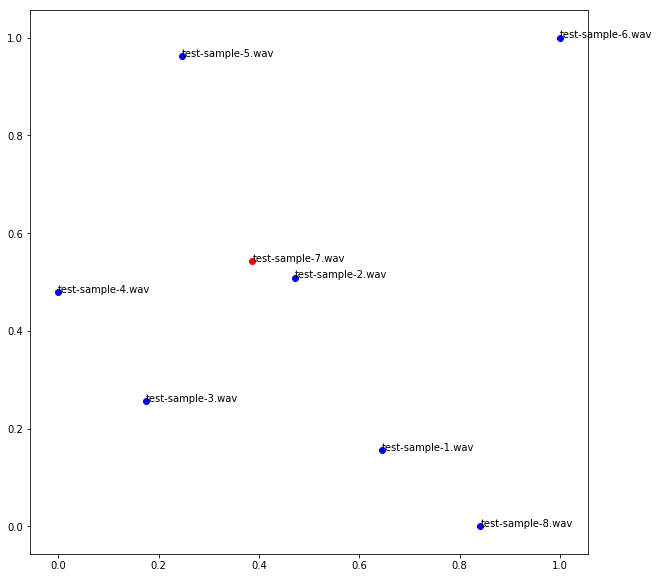

In [33]:
plt.figure(figsize=(10, 10))
plt.scatter(pca.T[0], pca.T[1], color='blue')
plt.scatter(projected_point.T[0], projected_point.T[1], color='red')
for i, label in enumerate(file_names):
    plt.annotate(label, (pca.T[0][i], pca.T[1][i]))
plt.annotate(extra_audio_file, (projected_point.T[0], projected_point.T[1]))
plt.show()